In [1]:
import os
import sys
sys.path.append('E:/xinlib')

import numpy as np

from base.file import NameBunch
from xcv import LoaderImage

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\h5py\tests\old\test_attrs_data.py:251: DeprecationWarning: invalid escape sequence \H
  s = b"Hello\x00\Hello"


In [2]:
root  = 'E:/Data/Badidu/'
nb = NameBunch(root)
nb.name2bunch

{'datasets': {'Z': <zipfile.ZipFile filename='E:/Data/Badidu/datasets.zip' mode='r'>},
 'datasets_fusai': {'Z': <zipfile.ZipFile filename='E:/Data/Badidu/datasets_fusai.zip' mode='r'>}}

In [3]:
Z = nb.name2bunch.datasets.Z

各个类下的样本大小：


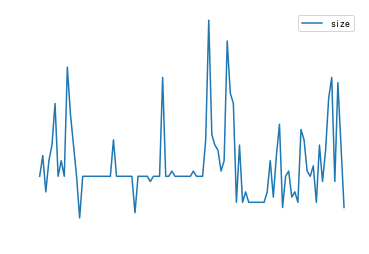

In [4]:
L = LoaderImage(Z, 224)

In [5]:
n_class = L.N2I.ZF.size_df.size

In [6]:
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models


class TR(nn.HybridBlock):
    def __init__(self, features, **kwargs):
        super().__init__(**kwargs)
        self.features = features
        with self.features.name_scope():
            self.output = nn.HybridSequential()
            self.output.add(
                nn.Dense(1000),
                nn.Activation('relu'),
                #nn.Dropout(0.5),
                nn.Dense(700),
                nn.Activation('relu'),
                nn.Dense(n_class)
            )
            
    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

In [11]:
ctx = mx.gpu(0)
batch_size = 8

In [12]:
net = models.densenet201(pretrained=True, ctx=ctx)
finetune_net = models.densenet201(classes=n_class)
finetune_net.features = net.features
finetune_net.output.initialize(mx.init.MSRAPrelu(), ctx =ctx)
finetune_net.hybridize()

In [13]:
for imgs, labels in L.data_iter(1, L.trainset, batch_size, True):
    imgs = imgs.as_in_context(ctx)
    break

finetune_net(imgs)

MXNetError: [15:51:57] c:\jenkins\workspace\mxnet-tag\mxnet\src\storage\pooled_storage_manager.h:108: cudaMalloc failed: out of memory

In [10]:
L.train((1, 2), ctx, finetune_net, 500, batch_size)

MXNetError: [15:51:40] c:\jenkins\workspace\mxnet-tag\mxnet\src\storage\pooled_storage_manager.h:108: cudaMalloc failed: out of memory